In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
from pandas_ml_common import Constant
from pandas_ml_utils import FeaturesAndLabels, Model
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_quant import pd, np, PostProcessedFeaturesAndLabels

# make experiments reproducable
import torch as t
t.manual_seed(0)

# globals
SYMBOL = "T"
START_DATE = "1995-01-01"
MODEL_REPOSITORY = "/home/kic/models"
# evetually PFE >= 1997-01-01

automatically imported pandas_ml_utils 0.1.5


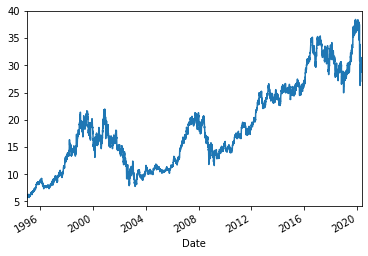

In [2]:
df = pd.fetch_yahoo(SYMBOL)[START_DATE:] if START_DATE is not None else pd.fetch_yahoo(SYMBOL)
df["Close"].plot()

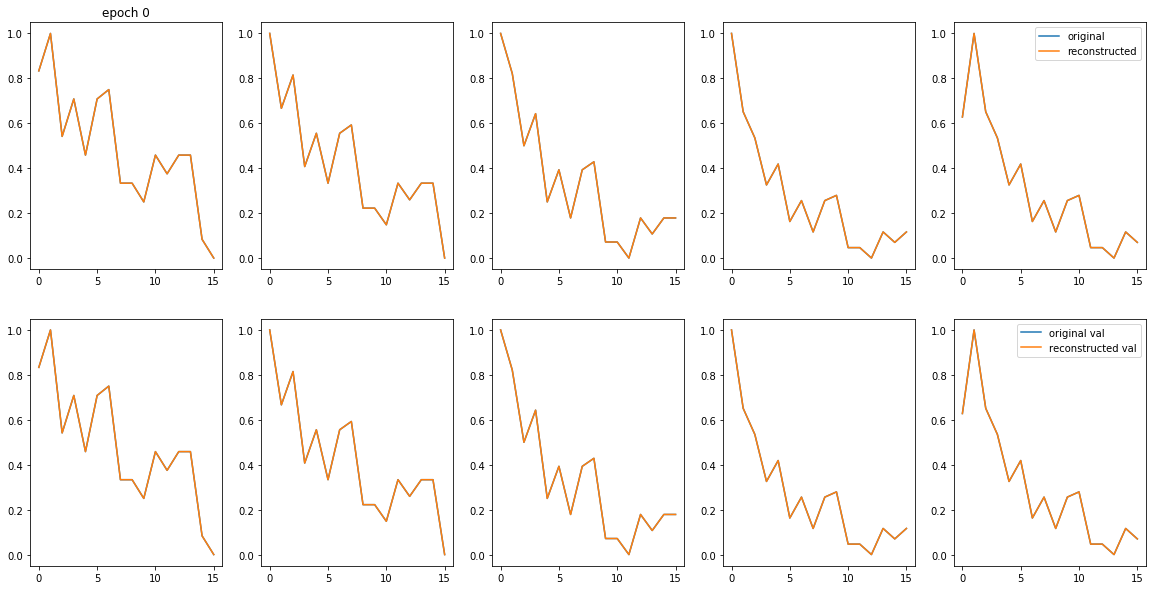

,Close_gaf
Date,
2020-05-04,"[[-0.9912015826738856, -0.958938135695799, -0...."
2020-05-05,"[[-0.9620470637234488, -0.9791484670551369, -0..."
2020-05-06,"[[-1.0, -0.9330107544676267, -0.95176814577174..."
2020-05-07,"[[-0.9971303948576675, -0.9992823411973384, -0..."
2020-05-08,"[[-0.7130394857667586, -0.9104713113234343, -0..."


In [3]:
from pandas_ml_quant.analysis.encoders import np_inverse_gaf
from IPython.display import clear_output

def plot_callback(y, y_hat, y_val, y_hat_val, epoch):
    clear_output(wait=True)
    fig, ax = plt.subplots(2, 5, figsize=(20, 10))    
    ax[0, 0].set_title(f'epoch {epoch}')

    for i in range(5):
        _y = np_inverse_gaf(y[i])[0]
        _y_hat = np_inverse_gaf(y_hat[i])[0]

        _y_val = np_inverse_gaf(y_val[i])[0]
        _y_hat_val = np_inverse_gaf(y_hat_val[i])[0]
        
        ax[0, i].plot(_y, label="original")
        ax[0, i].plot(_y_hat, label="reconstructed")
        ax[1, i].plot(_y_val, label="original val")
        ax[1, i].plot(_y_hat_val, label="reconstructed val")
        
    ax[0, -1].legend()
    ax[1, -1].legend()
    plt.show()
            
f_n_l = FeaturesAndLabels(
    [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
    [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
    targets = [lambda df: df["Close"] > df["Close"].shift(16)]
)

(f, _), l, tg, w, gl = df._.extract(f_n_l)
label = l._.values

# plot and simulate a batch
plot_callback(label[:10], label[:10], label[:10], label[:10], 0)

f.tail()

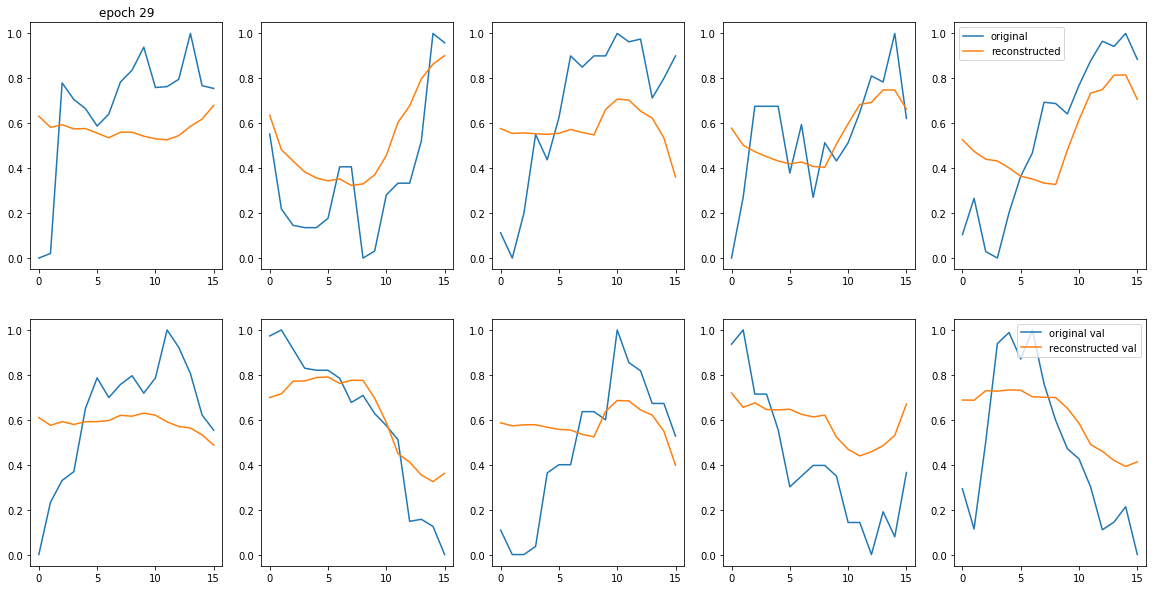

In [4]:
import torch as t
import torch.nn as nn
from torch.optim import Adam, Adagrad, RMSprop
from pandas_ml_utils import FeaturesAndLabels, PytorchModel, AutoEncoderModel
from pandas_ml_utils.pytorch import Reshape
from pandas_ml_quant.pytorch.custom_loss import SoftDTW

class AutoEncoder(nn.Module):
    # conv2D: in_channels, out_channels, kernel_size, stride=1, padding=0,
    # out = (input - kernel + 2padding) / stride
    def __init__(self, activation = nn.Tanh):
        super().__init__()
        self.activation = activation
        
        self._encoder = nn.Sequential(
            nn.Dropout(0.1),
            nn.Conv2d(1, 16, 3, padding=1),  # 16 - 3 + 2*1 / 1 + 1 => (?, 16, 16)
            activation(),
            nn.MaxPool2d(2, 2),              # (16 - 2) / 2 +1 => 8
            nn.Conv2d(16, 4, 3, padding=1),
            activation(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(4, 1, 3, padding=1),
            activation(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten()            
        )
        
        self._decoder = nn.Sequential(            
            Reshape(1, 2, 2),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(1, 4, 3, padding=1),
            activation(),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(4, 16, 3, padding=1),
            activation(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(16, 1, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        _x = x
        _x = self._encoder(_x)
        _x = self._decoder(_x)
        return _x

    def encoder(self, x):
        with t.no_grad():
            return self._encoder(t.from_numpy(x).float()).numpy()

    def decoder(self, x):
        with t.no_grad():
            return self._decoder(t.from_numpy(x).float()).numpy()



model = AutoEncoderModel(
    PytorchModel(
        FeaturesAndLabels(
            [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
            [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True).shift(-8)],
        ),
        AutoEncoder,
        nn.MSELoss,
        Adam,
    ),
    [f"condensed{i}" for i in range(4)],
    lambda m: m.module.encoder,
    lambda m: m.module.decoder,
)

ae_fit = df.model.fit(
    model, 
    epochs=30, 
    batch_size=32, 
    on_epoch=[plot_callback]
)

saved model to: /home/kic/models/T-predictive-ConvAE.model


prediction                                   \
           condensed0 condensed1 condensed2 condensed3   
Date                                                     
2020-05-04  -0.232927   0.164991  -0.484604   0.342791   
2020-05-05  -0.210856   0.154545  -0.415610   0.154156   
2020-05-06  -0.253430  -0.073242  -0.518571  -0.146082   
2020-05-07  -0.106257  -0.128902  -0.330432  -0.252744   
2020-05-08   0.193972  -0.176973   0.019846  -0.415687   

                                                      feature  
                                                    Close_gaf  
Date                                                           
2020-05-04  [[-0.9912015826738856, -0.958938135695799, -0....  
2020-05-05  [[-0.9620470637234488, -0.9791484670551369, -0...  
2020-05-06  [[-1.0, -0.9330107544676267, -0.95176814577174...  
2020-05-07  [[-0.9971303948576675, -0.9992823411973384, -0...  
2020-05-08  [[-0.7130394857667586, -0.9104713113234343, -0...

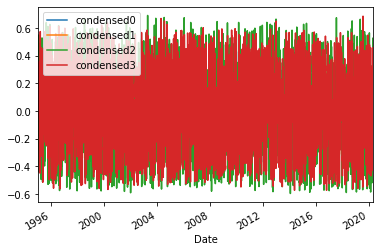

In [5]:
import torch as t

ae_model = ae_fit.model
encoder_model = ae_model.as_encoder()
encoder_model.save(f"{MODEL_REPOSITORY}/{SYMBOL}-predictive-ConvAE.model")
encoded = df.model.predict(encoder_model)
encoded["prediction"].plot()
encoded.tail()

saved model to: /home/kic/tmp/T_p_conv_ae.model


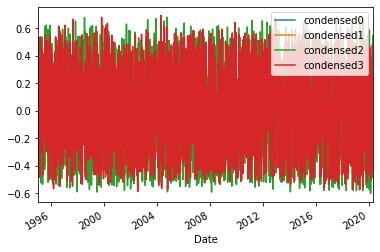

In [6]:
ae_fit.model.save(f"/home/kic/tmp/{SYMBOL}_p_conv_ae.model")
m2 = Model.load(f"/home/kic/tmp/{SYMBOL}_p_conv_ae.model")
df.model.predict(m2.as_encoder())["prediction"].plot()

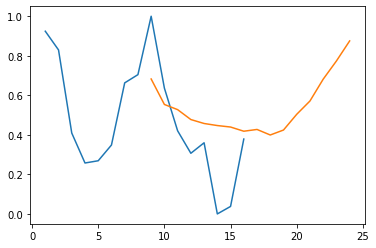

In [7]:
df = pd.fetch_yahoo(SYMBOL)[START_DATE:] if START_DATE is not None else pd.fetch_yahoo(SYMBOL)

ae_model = ae_fit.model # Model.load(f"/home/kic/tmp/{SYMBOL}_p_conv_ae.model")
ae_prediction = df.model.predict(ae_model, tail=1)

x1 = np.arange(1, 17)
y1 = df[-16:]["Close"].ta.rescale((0, 1)).values

x2 = np.arange(9, 9 + 16)
y2 = ae_prediction["prediction", "Close_gaf"].ta.inverse_gasf().values[0]

plt.plot(x1, y1)
plt.plot(x2, y2)

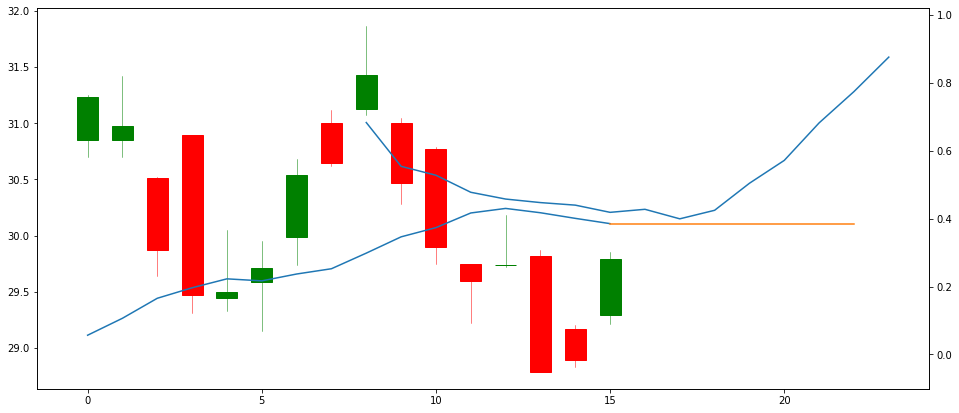

In [8]:
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc, plot_day_summary2_ohlc, candlestick2_ochl, candlestick2_ohlc


tail = df._[["Open", "High", "Low", "Close", lambda f: f["Close"].ta.sma(20)]].tail(16)
#display(tail)

fig, ax = plt.subplots(1, 1, figsize=(16, 7))
ax2 = ax.twinx()

#candlestick_ohlc(ax, (np.arange(len(tail)), tail["Open"], tail["High"], tail["Low"], tail["Close"] ))
#mpf.plot(df.tail(), type='candle')
#plot_day_summary2_ohlc(ax, tail["Open"], tail["High"], tail["Low"], tail["Close"])
#candlestick2_ohlc(ax, tail["Open"], tail["High"], tail["Low"], tail["Close"])
tail["Date"] = np.arange(len(tail))
cs = candlestick_ohlc(ax, tail[["Date", "Open", "High", "Low", "Close"]].values, width=0.6, colorup='g', colordown='r')
ax.plot(tail["Date"], tail["Close_sma_20"])
ax.plot(range(15, 15 + 8), np.repeat(tail["Close_sma_20"][-1], 8))

x2 = np.arange(8, 8 + 16)
y2 = ae_prediction["prediction", "Close_gaf"].ta.inverse_gasf()

#ax.plot(range(15, 15 + 8), y2[-1:].ta.rescale( (tail["Close_sma_20"][-1] - y2[-1:][8].values[0], tail["High"].max()) ).values[0, 8:])
#ax.plot(range(15, 15 + 8), y2[-1:].ta.rescale( (tail["Close"].min(), tail["Close"].max()) ).values[0, 8:])
#ax2.plot(range(15, 15 + 8), y2[-1:].values[0, 8:])
ax2.plot(range(8, 8 + 16), y2[-1:].values[0])
ax2.set_ylim((tail["Close"].min() / ax.get_ylim()[1] - 1, 1 * ax.get_ylim()[1] / tail["Close"].max()))
ax

In [9]:
tail["Close"].min() / ax.get_ylim()[1] - 1

-0.10098675993005246